In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
import json
import pyproj as pj
import halfspace.load as hs
import halfspace.sandbox as hbx
import time
import h5py

In [3]:
#dem_dataset = gdal.Open('../data/dem/nepal_eq_utm45n_500m_clip.tif')
dem_dataset = gdal.Open('../data/dem/s_tibet_utm45n_500m_clip.tif')

In [4]:
# write GeoTransform parameters to dictionary

dem_transform = {'upper_left_x': dem_dataset.GetGeoTransform()[0],
                 'x_res_m' : dem_dataset.GetGeoTransform()[1],
                 'x_rotation': dem_dataset.GetGeoTransform()[2],
                 'upper_left_y': dem_dataset.GetGeoTransform()[3],
                 'y_rotation': dem_dataset.GetGeoTransform()[4],
                 'y_res_m': dem_dataset.GetGeoTransform()[5],
                 'n_cols': dem_dataset.RasterXSize,
                 'n_rows': dem_dataset.RasterYSize}

dem_transform['y_res_m'] *= -1 # correct for the upper-left origin thing

print(dem_transform)

{'upper_left_y': 3650189.109228576, 'upper_left_x': -345300.6406560004, 'x_res_m': 423.895245806536, 'n_cols': 3763, 'n_rows': 2548, 'y_rotation': 0.0, 'y_res_m': 423.895245806536, 'x_rotation': 0.0}


In [5]:
dem_transform['east_min'] = dem_transform['upper_left_x']

dem_transform['east_max'] = (dem_transform['x_res_m'] * dem_transform['n_cols']
                             + dem_transform['east_min'])

dem_transform['north_max'] = dem_transform['upper_left_y']

dem_transform['north_min'] = (-1 * dem_transform['y_res_m'] * dem_transform['n_rows']
                              + dem_transform['north_max'])

In [6]:
# get latitude and longitude for the corners of the array, just 'cause.

wgs84 = pj.Proj(init='epsg:4326')
utm45n = pj.Proj(init='epsg:32645')

dem_transform['lon_min'], dem_transform['lat_min'] = pj.transform(utm45n, 
                                                        wgs84,
                                                        dem_transform['east_min'], 
                                                        dem_transform['north_min'])

dem_transform['lon_max'], dem_transform['lat_max'] = pj.transform(utm45n, 
                                                        wgs84,
                                                        dem_transform['east_max'], 
                                                        dem_transform['north_max'])

In [7]:
#with open('../data/dem/nepal_dem_meta.json', 'w') as f:
with open('../data/dem/s_tibet_dem_meta.json', 'w') as f:
    json.dump(dem_transform, f)

In [8]:
# read DEM data as numpy array
dem = dem_dataset.GetRasterBand(1).ReadAsArray()

dem = dem.astype('float')

dem.dtype

dtype('float64')

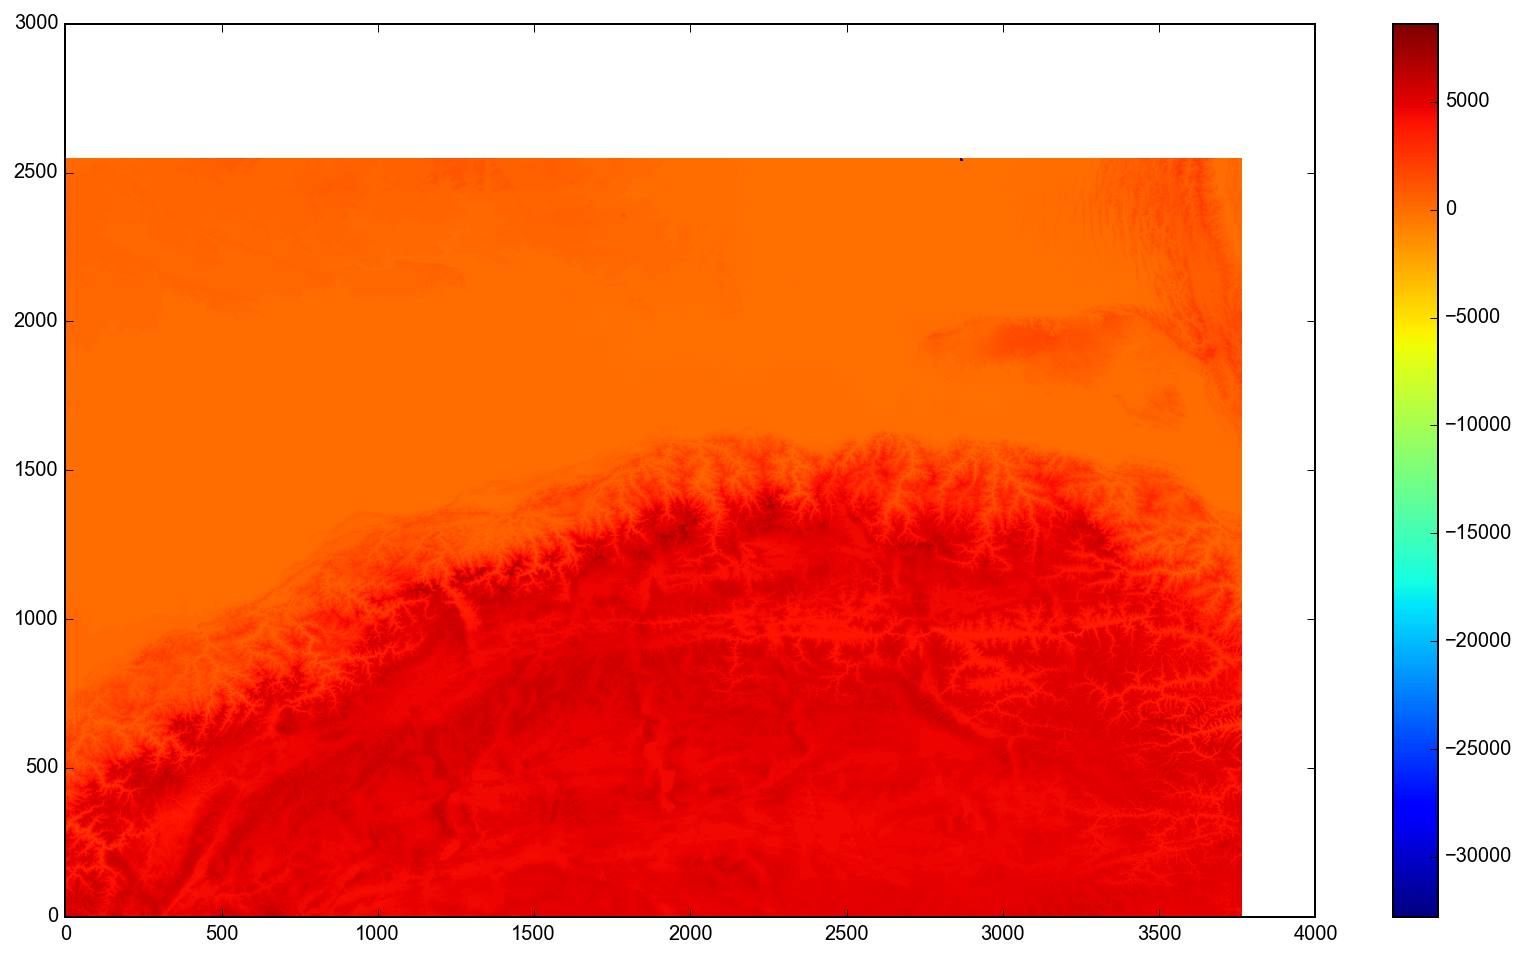

In [9]:
# look at dem

plt.figure(figsize=(14,8))

plt.pcolormesh(dem)
plt.colorbar()

plt.show()

In [10]:
# some nodata values are likely present

dem[dem < 0] = 0.

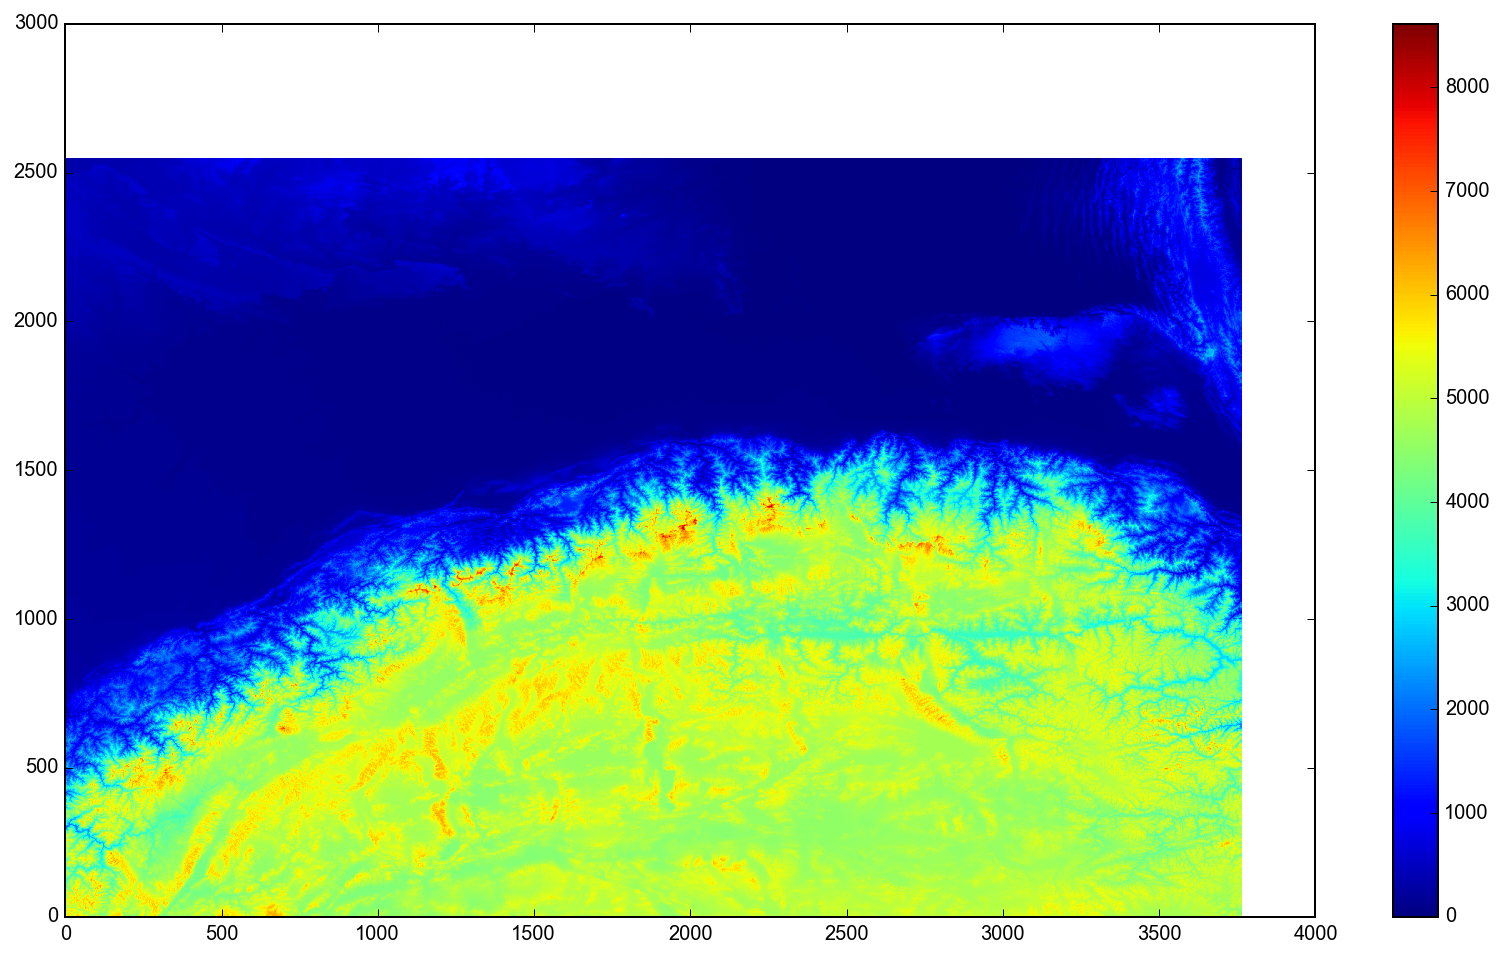

In [11]:
# look at dem

plt.figure(figsize=(14,8))

plt.pcolormesh(dem)
plt.colorbar()

plt.show()

In [12]:
dem = np.flipud(dem)

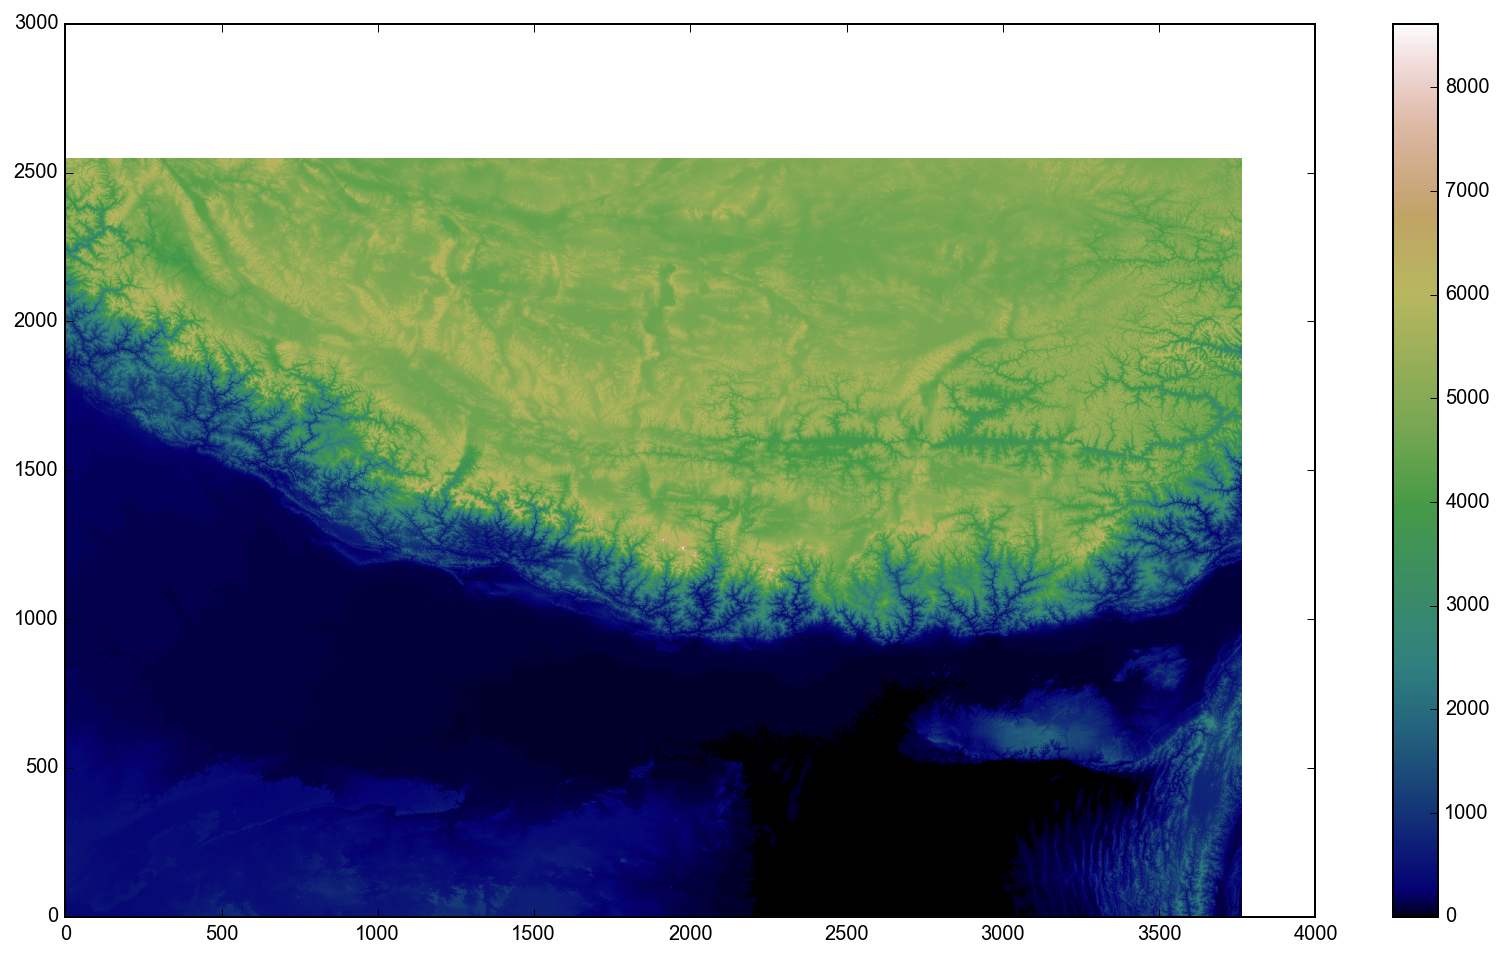

In [13]:
# let's look again, with a better color scheme
# look at dem

plt.figure(figsize=(14,8))

plt.pcolormesh(dem,
               cmap=plt.cm.gist_earth)
plt.colorbar()

plt.show()

## Boussinesq calculations

In [14]:
stress_dir = '../stress_arrays/'
b_stress_file = stress_dir + 'nepal_bouss_stress.h5'
c_stress_file = stress_dir + 'nepal_cerr_stress.h5'
stress_file = stress_dir + 'nepal_topo_stress.h5'

In [15]:
rho = 2700  # density in kg m^-3
g = 9.81    # gravitational force in m s^-2
Fv = - rho * g
study_res = int(dem_transform['x_res_m']) # resolution for topography, filters, etc.
z_res = 500
b_conv_mode = 'valid'
c_conv_mode = 'same'

z_min = z_res
z_max = z_min + 25000
z_len = int( (z_max - z_min) / z_res + 1)
z_vec = np.linspace(z_min, z_max, num=z_len)

kernel_rad = 2e5
kernel_len = int( kernel_rad * 2 / study_res +1 )
kernel_shape = np.array( [kernel_len, kernel_len] )

In [16]:
dem *= -1 # topo is negative in our convention

In [17]:
b_out_x, b_out_y = hbx.size_output(kernel_shape, dem.shape,
                                   mode=b_conv_mode)

b_out_size = np.array((b_out_x, b_out_y, z_len))
b_stress_empty = np.zeros( (b_out_size))

b_db = h5py.File(b_stress_file, mode='w')
b_dict = {}
comp_list = ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']

In [18]:
t2 = time.time()
for comp in comp_list:
    print('working on {} stresses'.format(comp) )
    b_dict[comp] = b_stress_empty.copy()
    
    t_conv_start = time.time()
    for i, z in enumerate(z_vec):
        b_dict[comp][:,:,i] = hs.do_b_convo(component=comp,  z=z, 
                                            load=dem, 
                                            Fv=Fv, load_mode='topo',
                                            conv_mode=b_conv_mode, 
                                            kernel_radius=kernel_rad,
                                            kernel_res=study_res)
    t_conv_stop = time.time()
    print(t_conv_stop - t_conv_start, 'secs for convolution')
    b_dict[comp] *= 1e-6  # scale results to MPa
    
    b_db.create_dataset('b_{}_MPa'.format(comp), data = b_dict[comp],
                     chunks = True, compression = 'gzip')

    del b_dict[comp]

print('done with Boussinesq calcs in', (time.time() - t2) / 60., 'm')

working on xx stresses
146.45262098312378 secs for convolution
working on yy stresses
140.45325803756714 secs for convolution
working on zz stresses
139.8787009716034 secs for convolution
working on xy stresses
143.45941710472107 secs for convolution
working on xz stresses
138.43017888069153 secs for convolution
working on yz stresses
136.97511100769043 secs for convolution
done with Boussinesq calcs in 32.07422184944153 m


## Cerruti calculations

In [19]:
# Boussinesq stresses for xx, xy and yy are used in the loading function
b_xx_top = b_db['b_xx_MPa'][:,:,0] * 1e6
b_xy_top = b_db['b_xy_MPa'][:,:,0] * 1e6
b_yy_top = b_db['b_yy_MPa'][:,:,0] * 1e6
b_shape = b_xx_top.shape

topo = hs._centered(dem, b_shape)

topo_dy, topo_dx = np.gradient(topo, study_res)

In [20]:
# make horizontal loading functions
Fht_x = topo * Fv * topo_dx
Fhb_x = b_xx_top * topo_dx + b_xy_top * topo_dy 

Fht_y = topo * Fv * topo_dy
Fhb_y = b_yy_top * topo_dy + b_xy_top * topo_dx

Fh_x = Fht_x + Fhb_x
Fh_y = Fht_y + Fhb_y

In [21]:
# make Cerruti output arrays
c_x = np.zeros([topo.shape[0], topo.shape[1], z_len])
c_y = c_x.copy()
c_db = h5py.File(c_stress_file)
t_db = h5py.File(stress_file)

del topo # save some ram

cerr_x = {}
cerr_y = {}
total_dict = {}

In [22]:
t3 = time.time()
for comp in comp_list:
    print('working on {} stresses'.format(comp))

    cerr_x[comp] = c_x.copy()
    cerr_y[comp] = c_y.copy()

    for i, z in enumerate(z_vec):
        cerr_x[comp][:,:,i] = hs.do_c_convo(component=comp, f_dir='x',z=z,
                                            load=Fh_x, kernel_res=study_res,
                                            kernel_radius=kernel_rad,
                                            conv_mode=c_conv_mode) * 1e-6

        cerr_y[comp][:,:,i] = hs.do_c_convo(component=comp, f_dir='y', z=z,
                                            load=Fh_y, kernel_res=study_res,
                                            kernel_radius=kernel_rad,
                                            conv_mode=c_conv_mode) * 1e-6

    print('saving {} data'.format(comp))
    c_db.create_dataset('c_{}_x_MPa'.format(comp), 
                      data = cerr_x[comp], chunks=True, compression = 'gzip')

    c_db.create_dataset('c_{}_y_MPa'.format(comp), 
                      data = cerr_y[comp], chunks=True, compression = 'gzip')

    print('adding all results together')
    total_dict[comp] = (b_db['b_{}_MPa'.format(comp)][:,:,:] +  cerr_x[comp] 
                        + cerr_y[comp] )

    t_db.create_dataset('{}_MPa'.format(comp), data=total_dict[comp],
                        chunks = True, compression = 'gzip')

    del total_dict[comp]
    del cerr_x[comp]
    del cerr_y[comp]

print('done with topo corrections in', (time.time() - t3) / 60., 'm')

working on xx stresses


KeyboardInterrupt: 

In [ ]:
b_db.close()
c_db.close()
t_db.close()